In [1]:
import numpy as np
import geopandas as gp
import pandas as pd
from rasterio.plot import show
import rasterio as rio
import rasterio.features
import rasterio.warp
import earthpy.spatial as es
import tarfile
import os
from shapely.geometry import Polygon
from matplotlib import pyplot
import matplotlib.pyplot as plt
import json
import pickle
import pyproj;                                 #pyproj.set_datapath("C:/Users/User/Anaconda3/envs/geo/Lib/site-packages/pyproj")
import landsatxplore.api
from landsatxplore.earthexplorer import EarthExplorer                                  # https://pypi.org/project/landsatxplore/
from collections.abc import Iterable
import time
import math
from ipypb import track
import seaborn as sn
from ipyleaflet import Map, GeoData, basemaps, LayersControl
import warnings

In [2]:
os.chdir("C:/Users/User/Documents/Work/SDGs and AI/6.3.2")
d_path = './Landsat/Downloaded/'
c_path = './Landsat/Cropped/'
c1_path = './Landsat/Cropped/Level 1/'
s_path = './Landsat/Scenes/'
m_path = './Landsat/Metadata/'
shp_path = './Shapefiles/'

### Hide splines

In [259]:
def hide_spines(ax, positions=['top', 'right']):
    """
    Pass a matplotlib axis and list of positions with spines to be removed
    
    args:
        ax:          Matplotlib axis object
        positions:   Python list e.g. ['top', 'bottom']
    """
    assert isinstance(positions, list), 'Position must be passed as a list '
    
    for position in positions:
        ax.spines[position].set_visible(False)

### Read in list of sites for download

In [3]:
#sites = pickle.load(open("sites.p","rb"))
sites = pd.read_pickle("sites.p")

In [3]:
### example site

sid = 'EL000200030020H500'

### Read shapefile

In [7]:
polygon = gp.read_file("./Shapefiles/brin.shp")
polygon_bbox = gp.GeoDataFrame(gp.GeoSeries(polygon.envelope), columns=['geometry'],crs=polygon.crs)

In [9]:
m = Map(center=(37.93007,22.28925 ), zoom = 14, basemap = basemaps.Esri.WorldTopoMap)

lakes_plot = GeoData(geo_dataframe = polygon,
                   style={'color': 'black', 'fillColor': '#3366cc', 'opacity':0.5, 'weight':1.9, 'dashArray':'2', 'fillOpacity':0.6},
                   hover_style={'fillColor': 'red' , 'fillOpacity': 0.2},
                   name = 'Large Lakes')

lakes_point = GeoData(geo_dataframe = sites.loc[sid,],
                   style={'color': 'black', 'fillColor': '#3366cc', 'opacity':0.5, 'weight':1.9, 'dashArray':'2', 'fillOpacity':0.6},
                   hover_style={'fillColor': 'red' , 'fillOpacity': 0.2},
                name = 'Large Lakes')

m.add_layer(lakes_plot)
m.add_layer(lakes_point)
m.add_control(LayersControl())

m

NameError: name 'sites' is not defined

### Clip and mask raster to polygon

#### Create function for cropping raster

In [3]:
def cropper(raster, geoms, outpath):
    """
    This function accepts a raster object, an interable list of geometrys (or a single geometry),
    and a filepath to save the cropped raster to, the cropped raster is then read back in and returned.
    """    
    ## As crop accepts an iterable of geoms we first put any single geoms into a list
    if not isinstance(geoms, Iterable):
        geoms = [geoms]

    ## Next we crop the image
    raster_crop, raster_crop_meta = es.crop_image(raster, geoms)

    ## We now need to update the metadata with the spatial data
    raster_crop_meta.update({'transform': raster_crop_meta['transform'],
                             'height': raster_crop.shape[1],
                             'width': raster_crop.shape[2],
                             'nodata': raster_crop.min()}) # <- This is the 'mask' value
    
    with rio.open(outpath, 'w', **raster_crop_meta) as file:
        file.write(raster_crop[0], 1)
        
    raster_crop = rio.open(outpath)
    
    return raster_crop

#### Run function on downloaded rasters and save to new directory

In [12]:
### List tif files in download directory to process
dl_files = os.listdir(d_path)
tif_files = [ i for i in dl_files if '.tif' in i ]

while len(tif_files)>0:

    for tif in tif_files:  ### AMEND TO be for specific scene

        with rio.open(d_path+tif) as src:
        
            ## set polygon to crs of raster
            polygon_newcrs = polygon.to_crs(src.crs)
            polygon_geom = polygon_newcrs.loc[0, 'geometry']
            
            try:
            
            ## crop raster to polygon extent
                cropped = cropper(src, polygon_geom, c_path+tif)
                
            except: 
                print(tif+' and polygon do not intercept')
                crop_exceptions = []
                crop_exceptions += tif

            ## close and delete uncropped version
            src.close()
            
            try:
                os.remove(d_path+tif)
            except:
                print(f'Cannot remove {tif}')

        ## update files list
        dl_files = os.listdir(d_path)
        tif_files = [ i for i in dl_files if '.tif' in i ]
        
        break
            
if len(tif_files)==0:
    print('No tifs to crop')


No tifs to crop


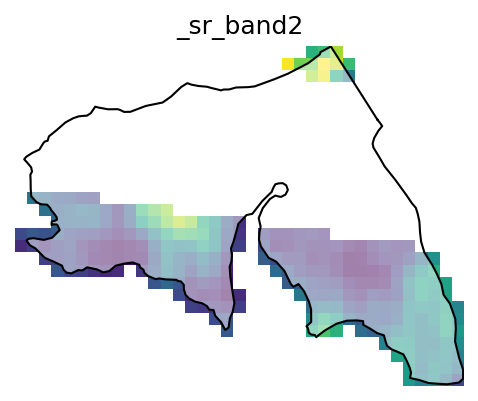

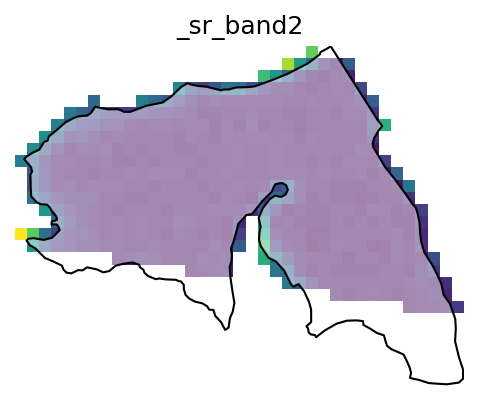

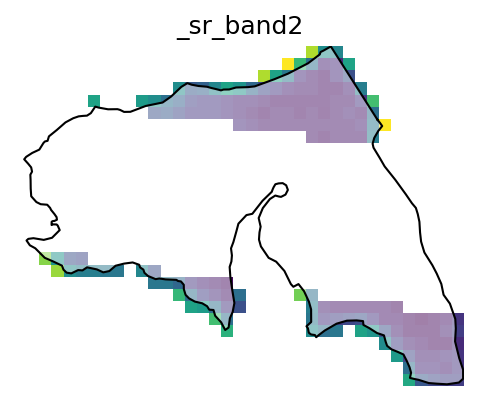

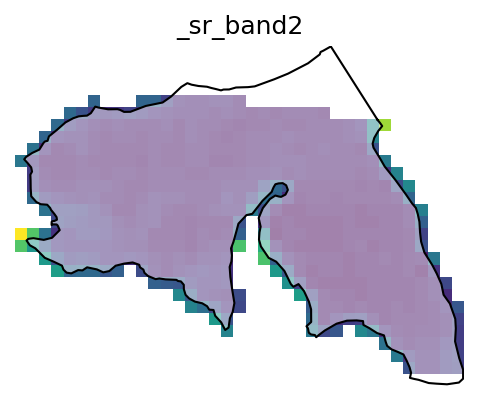

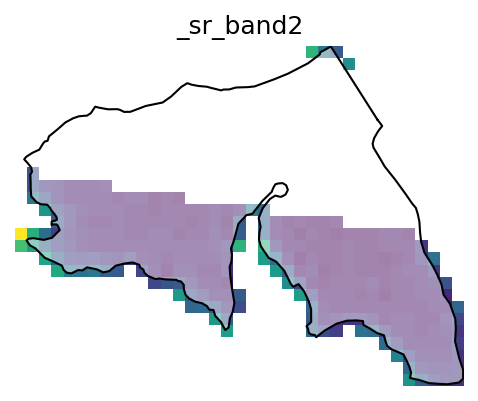

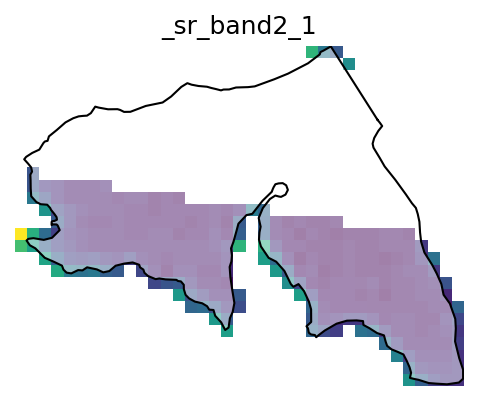

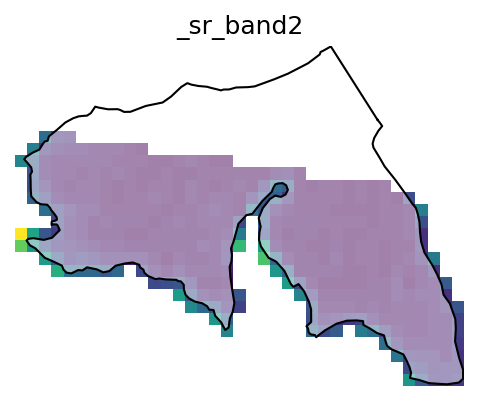

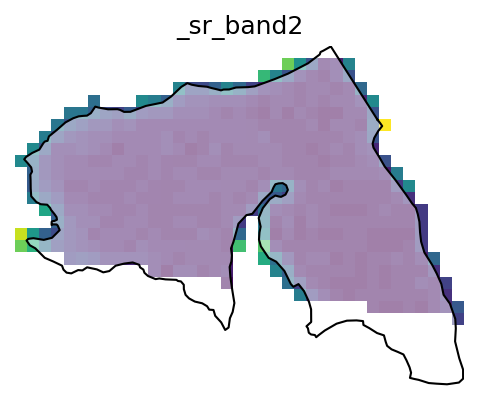

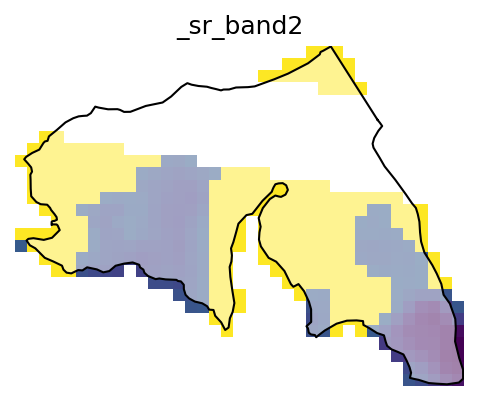

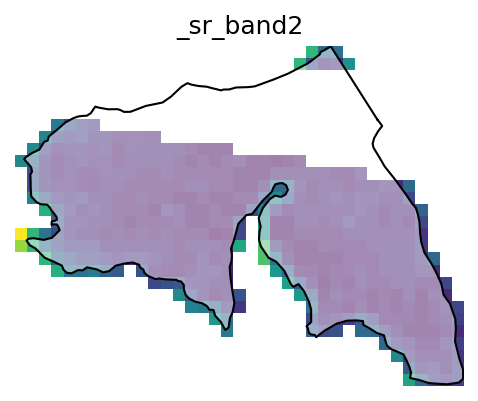

In [119]:
warnings.filterwarnings("ignore")

dl_files = os.listdir(c_path)
c_tif_files = [ i for i in dl_files if 'band2' in i ]

for tif in c_tif_files:
    
    with rio.open(c_path+tif) as src:
        
        data = src.read()
    
        if data.max() > 1:
                
            fig, ax = plt.subplots(dpi=150, figsize =(8, 3))

            show(src, ax=ax)
            polygon_newcrs.plot(alpha=0.5, color='white', ax=ax) # We plot both the filled in polygon
            ax.plot(*polygon_geom.exterior.xy, color='k', linewidth=1) # And add a darker border
            ax.set_title(tif.split('T1')[1].replace('.tif',''))
            
            ax.set_axis_off()
            
            src.close()

### Save local file version with downloaded setting

In [ ]:
localname = 'LC08_L1TP_042034_20170616_20170629_01_T1_NDVI_OVIEW.tif'

with rasterio.open(url+nirband) as src:
    profile = src.profile.copy()

    aff = src.transform
    newaff = rasterio.Affine(aff.a * oview, aff.b, aff.c,
                             aff.d, aff.e * oview, aff.f)
    profile.update({
            'dtype': 'float32',
            'height': ndvi.shape[0],
            'width': ndvi.shape[1],
            'transform': newaff})  

    with rasterio.open(localname, 'w', **profile) as dst:
        dst.write_band(1, ndvi)

### Plot raster

https://geohackweek.github.io/raster/04-workingwithrasters/

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


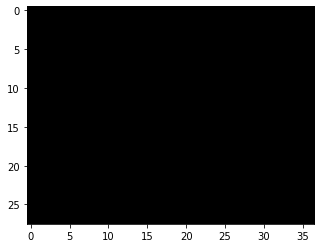

In [11]:
import matplotlib.image as mpimg

b1 = rio.open('./Landsat/Cropped/LC08_L1TP_184033_20130726_20180527_01_T1_sr_band1.tif')
b2 = rio.open('./Landsat/Cropped/LC08_L1TP_184033_20130726_20180527_01_T1_sr_band2.tif')
b3 = rio.open('./Landsat/Cropped/LC08_L1TP_184033_20130726_20180527_01_T1_sr_band3.tif')

b1 = b1.read(1)
b2 = b2.read(1)
b3 = b3.read(1)

rgb = np.dstack((b1,b2,b3))
    

plt.imshow(rgb)

plt.show()

C:\Users\User\Anaconda3\envs\geo\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


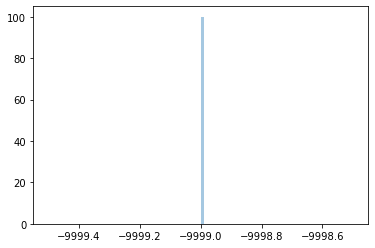

In [12]:
### 65,536 for 16-bit

import seaborn as sn

sn.distplot(rgb,bins=100)

### Look at netCFD xarray

In [29]:
# Read the src's valid data mask as a ndarray.
mask = src.dataset_mask()

# Extract feature shapes and values from the array.
for geom, val in rio.features.shapes(
        mask, transform=src.transform):

    # Transform shapes from the src's own coordinate
    # reference system to CRS84 (EPSG:4326).
    geom = rio.warp.transform_geom(
        src.crs, 'EPSG:4326', geom, precision=6)

    # Print GeoJSON shapes to stdout.
    print(geom)

SyntaxError: unexpected EOF while parsing (<ipython-input-29-dc499ada0354>, line 16)

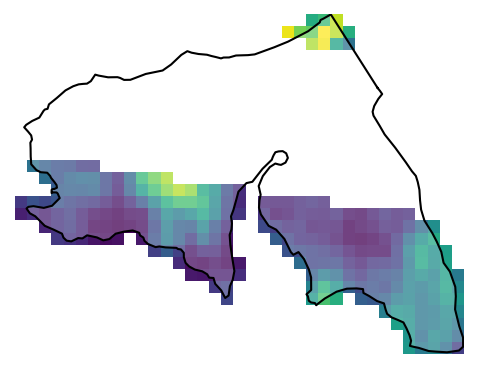

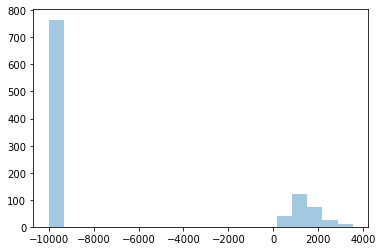

In [47]:
path = './Landsat/Cropped/'

with rio.open(path+'LE07_L1TP_183034_20130609_20161124_01_T1_sr_band1.tif') as src:

    polygon_newcrs = polygon.to_crs(src.crs)
    polygon_geom = polygon_newcrs.loc[0, 'geometry']
    
    fig, ax = plt.subplots(dpi=150, figsize =(8, 3))

    show(src, ax=ax)
    polygon.plot(alpha=0.25, color='white', ax=ax) # We plot both the filled in polygon
    ax.plot(*polygon_geom.exterior.xy, color='k', linewidth=1) # And add a darker border

    ax.set_axis_off()
    
    plt.show()
    
    sn.distplot(src.read(),kde=False,bins=20)

In [66]:
d_path = './Landsat/Downloaded/'
c_path = './Landsat/Cropped/'

dl_files = os.listdir(d_path) 
dl_files += os.listdir(c_path) 
dl_files

['Orders',
 'Thumbs.db',
 'LC08_L1TP_184033_20130726_20180527_01_T1.xml',
 'LC08_L1TP_184033_20130726_20180527_01_T1_pixel_qa.tif',
 'LC08_L1TP_184033_20130726_20180527_01_T1_radsat_qa.tif',
 'LC08_L1TP_184033_20130726_20180527_01_T1_sr_aerosol.tif',
 'LC08_L1TP_184033_20130726_20180527_01_T1_sr_band1.tif',
 'LC08_L1TP_184033_20130726_20180527_01_T1_sr_band2.tif',
 'LC08_L1TP_184033_20130726_20180527_01_T1_sr_band3.tif',
 'LC08_L1TP_184033_20130726_20180527_01_T1_sr_band4.tif',
 'LC08_L1TP_184033_20130726_20180527_01_T1_sr_band5.tif',
 'LC08_L1TP_184033_20130726_20180527_01_T1_sr_band6.tif',
 'LC08_L1TP_184033_20130726_20180527_01_T1_sr_band7.tif',
 'LC08_L1TP_184033_20150614_20170408_01_T1_pixel_qa.tif',
 'LC08_L1TP_184033_20150614_20170408_01_T1_radsat_qa.tif',
 'LC08_L1TP_184033_20150614_20170408_01_T1_sr_band1.tif',
 'LC08_L1TP_184033_20150614_20170408_01_T1_sr_band2.tif',
 'LC08_L1TP_184033_20150614_20170408_01_T1_sr_band3.tif',
 'LC08_L1TP_184033_20150614_20170408_01_T1_sr_band4.

In [110]:
src = rio.open(c_path+'LE07_L1TP_183034_20140831_20161112_01_T1_sr_band1.tif')
src.close()

os.remove(c_path+'LE07_L1TP_183034_20140831_20161112_01_T1_sr_band1.tif')

PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: './Landsat/Cropped/LE07_L1TP_183034_20140831_20161112_01_T1_sr_band1.tif'

In [131]:
site_range

,value
sid,
ATSE20101000,10.0
ATSE20201000,6.0
ATSE20301000,3.0
ATSE20401000,15.0
ATSE20501000,4.0
...,...
UKSC302233,15.5
UKSC303610,2.3
UKSC375099,50.1


In [148]:
sites2 = sites[sites.value<150]
site_var = sites2['value'].reset_index().groupby('sid').var()
site_min = sites2['value'].reset_index().drop(['dt'],axis=1).groupby('sid').min()
site_max = sites2['value'].reset_index().drop(['dt'],axis=1).groupby('sid').max()
site_range = (site_max - site_min)
site_range = site_range.rename(columns = {'value':'range'})

In [149]:
site_var.head()

,value
sid,
ATSE20101000,12.093567
ATSE20201000,2.879085
ATSE20301000,0.764706
ATSE20401000,13.830409
ATSE20501000,1.035088


In [150]:
site_var = site_var.merge(site_range.reset_index(),how='left',on='sid')
site_var = site_var.merge(sites['geometry'].reset_index(),how='left',on='sid')

In [151]:
site_var = site_var[sites_var.value.notna()]

In [152]:
site_var = gp.GeoDataFrame(site_var,crs=sites.crs)

In [154]:
boundaries = gp.read_file(shp_path+'CNTR_BN_60M_2016_3857.shp')
boundaries = boundaries.to_crs(site_var.crs)

In [160]:
import math
site_var['val_log'] = site_var.value.apply(lambda x: math.log1p(x**6))

site_var['range2'] = site_var.range/2

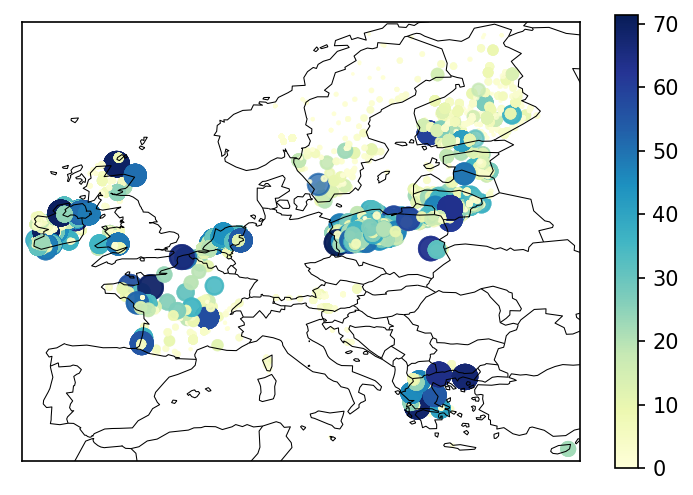

In [162]:
minx, miny, maxx, maxy = site_var.geometry.total_bounds


fig, ax = plt.subplots(dpi=150)

#hide_spines(ax, positions=['top', 'right','bottom','left'])

site_var.plot(ax=ax,column='range2',markersize='range',cmap='YlGnBu',legend=True,alpha=.5)
boundaries.plot(ax=ax,color='k',lw=.5)

ax.set_xlim(minx - 1, maxx + 1) 
ax.set_ylim(miny - 1, maxy + 1)

ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticks([])

plt.show()

### Selecting nearest pixels to sampling points

In [274]:
def crop_xpixels_point(point,raster,polygon,poly_buffer,n_pixels,outpath):
    '''
    Requires 
    - point: a Geopandas object
    - raster: a raster object as read by rasterio
    - poly_buffer: a buffer to be applied to polygon in units of CRS
    - n_pixels: number of required pixels to be returned
    - outpath: name and path for saving raster
    '''
    
    from rasterstats import zonal_stats
    import earthpy.spatial as es

    
    #~~~~ crop raster to internal water body ~~~~#
    
    with rio.open(raster) as src:
    
        assert point.crs==src.crs, f'CRS of {polygon} and {src} must be the same'

        geoms = polygon.buffer(poly_buffer).geometry

        ## Put any single geoms into a list
        if not isinstance(geoms, Iterable):
            geoms = [geoms]

        ## Crop raster in water body interior
        raster_crop, raster_crop_meta = es.crop_image(src, geoms)

        ## We now need to update the metadata with the spatial data
        raster_crop_meta.update({'transform': raster_crop_meta['transform'],
                                 'height': raster_crop.shape[1],
                                 'width': raster_crop.shape[2],
                                 'nodata': raster_crop.min()})
    
    with rio.open(outpath, 'w', **raster_crop_meta) as file:
        file.write(raster_crop[0], 1)
    
    src.close()  
      
    #~~~~ for loop to define buffer distance based on required pixels ~~~~#
    
    with rio.open(outpath) as src:
        
        assert point.crs==src.crs, f'CRS of {point} and {src} must be the same'
    
        pixel_count = 0

        for i in range(2,500,1):

            if pixel_count<n_pixels:

                pts_buf_geom = point.buffer(i).geometry

                ## Put any single geoms into a list
                if not isinstance(pts_buf_geom, Iterable):
                    pts_buf_geom = [pts_buf_geom]

                    try: 
                        ## Crop raster in water body interior
                        raster_crop, raster_crop_meta = es.crop_image(src, pts_buf_geom)

                        ## We now need to update the metadata with the spatial data
                        raster_crop_meta.update({'transform': raster_crop_meta['transform'],
                                                 'height': raster_crop.shape[1],
                                                 'width': raster_crop.shape[2],
                                                 'nodata': raster_crop.min()})

                        pixel_count = len(raster_crop[raster_crop>0])
                
                    except:
                        pixel_count = 0
                
                ## distance for required pixel number
                buf_dis = i-1
    
    with rio.open(outpath, 'w', **raster_crop_meta) as file:
        file.write(raster_crop[0], 1)
      
    pixels = rio.open(outpath)
    
    src.close()
    
    return pixels,pixel_count,buf_dis

#### Sample site

In [263]:
os.chdir("C:/Users/User/Documents/Work/SDGs and AI/6.3.2")

sites = pd.read_pickle("sites2.p")
sites = sites.reset_index().set_index(['sid','dt'])
sites = sites.set_geometry('geometry_poly')
sites = sites.drop(columns=['monitoringSiteIdentifier','wbid','thematicId'])

13


13

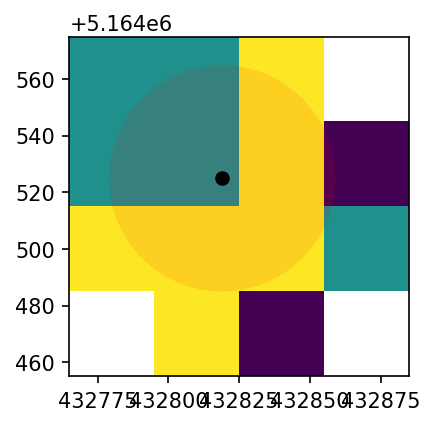

In [260]:
path = 'C:/Users/User/Documents/test.tif'

src,count,buf_dis = crop_xpixels_point(pts,sid_file[1],poly,-100,13,path)
 
fig, ax = plt.subplots(dpi=150, figsize =(5, 3))

#poly.plot(ax=ax)
pts.buffer(buf_dis).plot(ax=ax,color='r',alpha=0.1)
show(src,ax=ax)
pts.plot(ax=ax,color='k')


print(count)
data = src.read(1)
len(data[data>0])

C:\Users\User\Anaconda3\envs\geo\lib\site-packages\matplotlib\image.py:421: RuntimeWarning: overflow encountered in true_divide
  A_scaled /= ((a_max - a_min) / 0.8)
C:\Users\User\Anaconda3\envs\geo\lib\site-packages\matplotlib\image.py:421: RuntimeWarning: overflow encountered in true_divide
  A_scaled /= ((a_max - a_min) / 0.8)
C:\Users\User\Anaconda3\envs\geo\lib\site-packages\matplotlib\image.py:421: RuntimeWarning: overflow encountered in true_divide
  A_scaled /= ((a_max - a_min) / 0.8)
C:\Users\User\Anaconda3\envs\geo\lib\site-packages\matplotlib\image.py:421: RuntimeWarning: overflow encountered in true_divide
  A_scaled /= ((a_max - a_min) / 0.8)
C:\Users\User\Anaconda3\envs\geo\lib\site-packages\matplotlib\image.py:421: RuntimeWarning: overflow encountered in true_divide
  A_scaled /= ((a_max - a_min) / 0.8)
C:\Users\User\Anaconda3\envs\geo\lib\site-packages\matplotlib\image.py:421: RuntimeWarning: overflow encountered in true_divide
  A_scaled /= ((a_max - a_min) / 0.8)
C:\U

<ipython-input-276-090ca873c03d>:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(dpi=150, figsize =(5, 3))
<ipython-input-276-090ca873c03d>:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(dpi=150, figsize =(5, 3))
<ipython-input-276-090ca873c03d>:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.

<ipython-input-276-090ca873c03d>:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(dpi=150, figsize =(5, 3))
C:\Users\User\Anaconda3\envs\geo\lib\site-packages\matplotlib\image.py:421: RuntimeWarning: overflow encountered in true_divide
  A_scaled /= ((a_max - a_min) / 0.8)


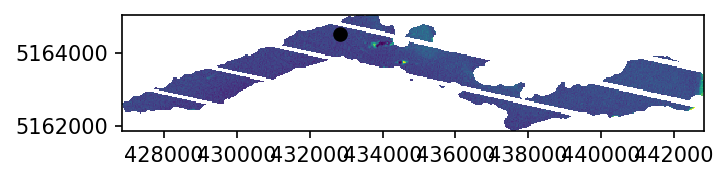

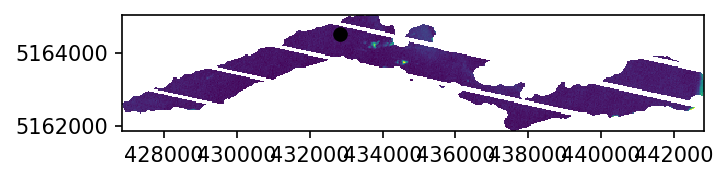

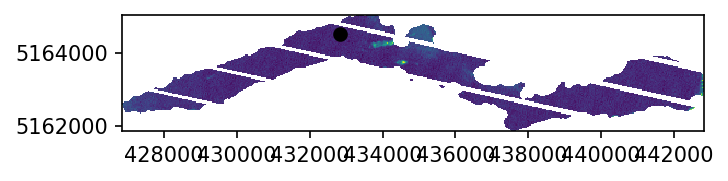

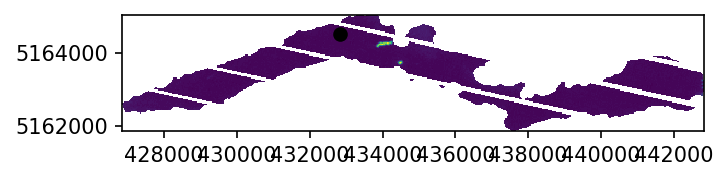

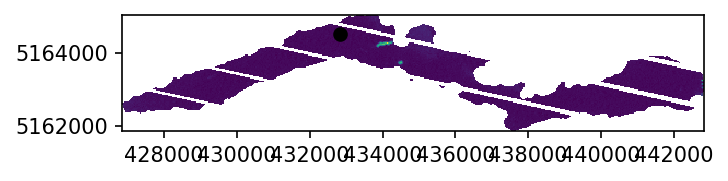

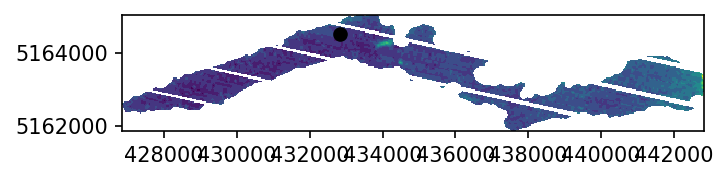

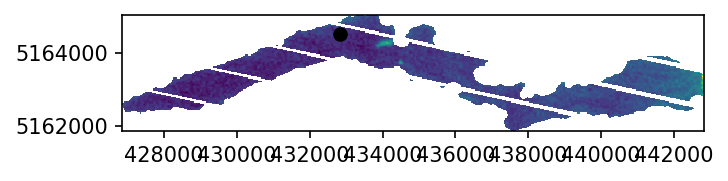

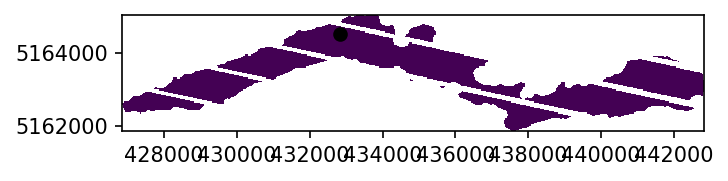

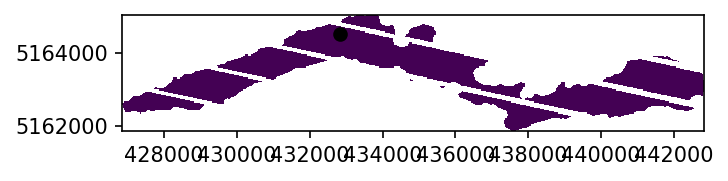

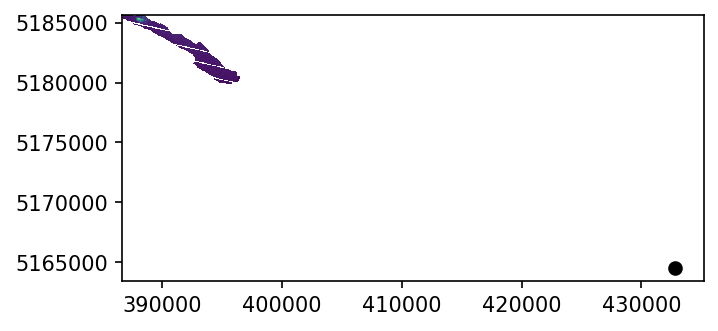

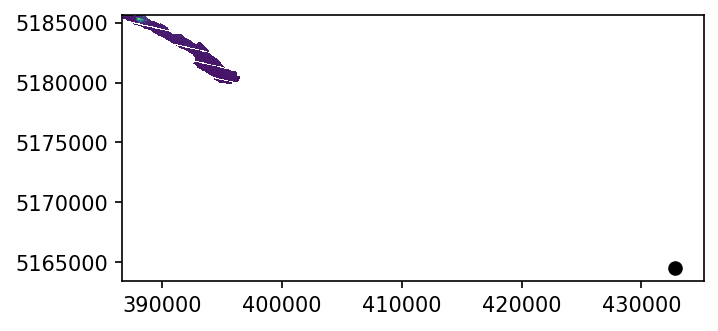

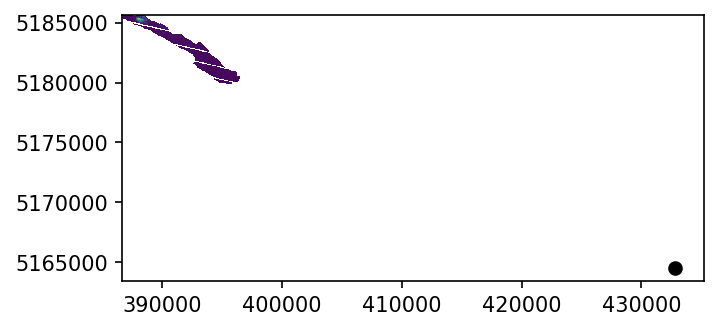

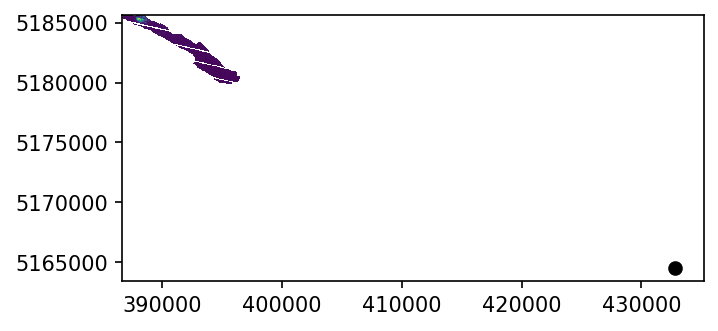

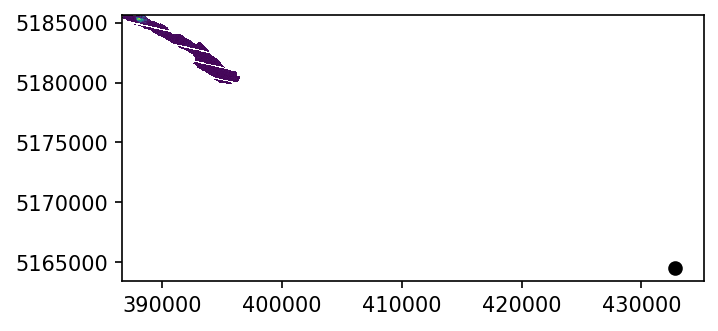

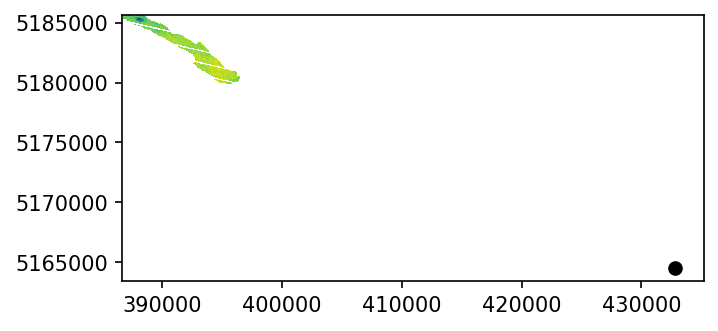

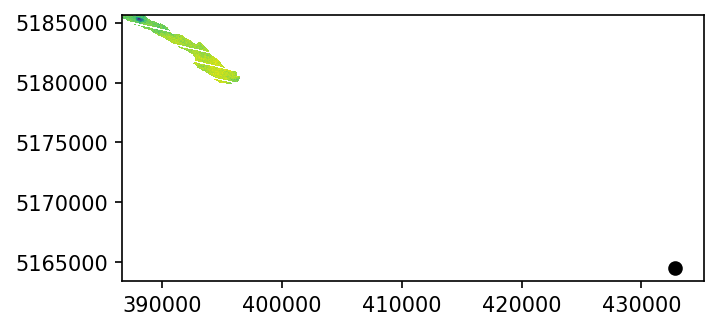

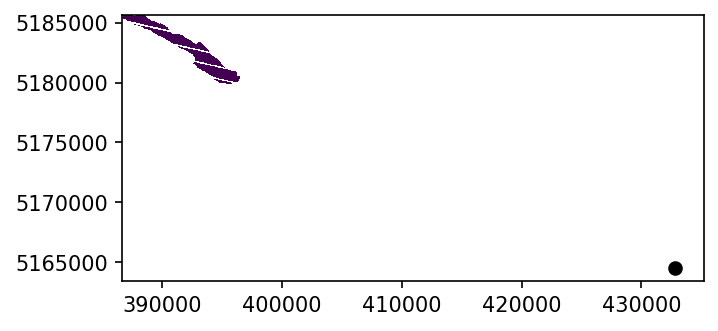

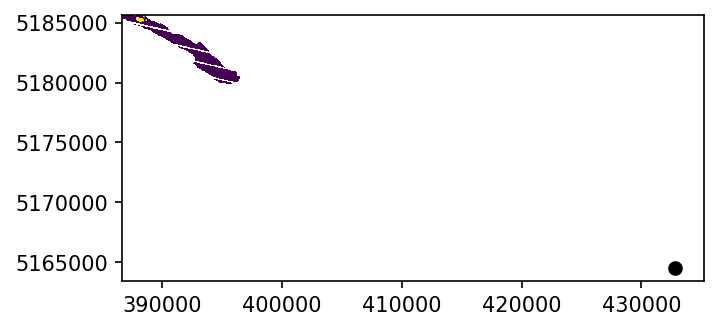

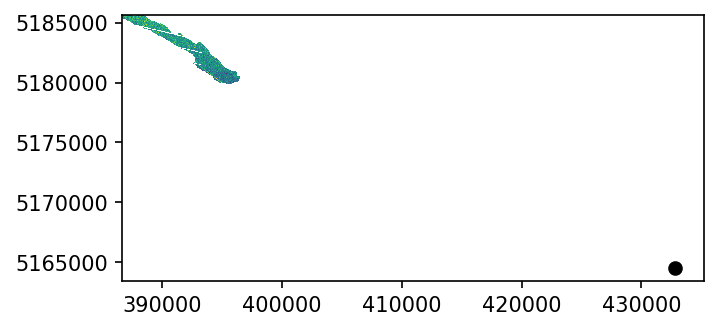

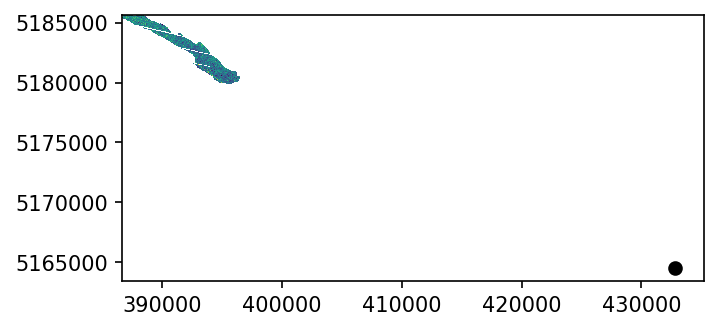

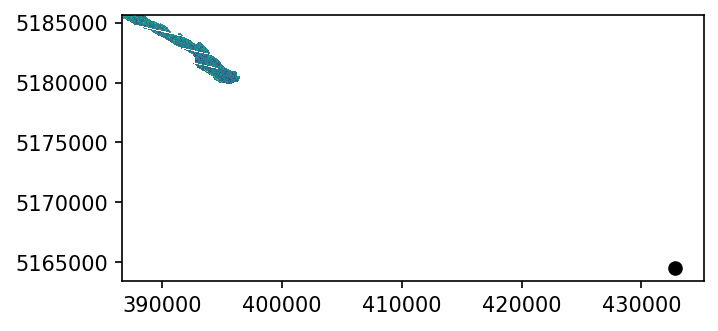

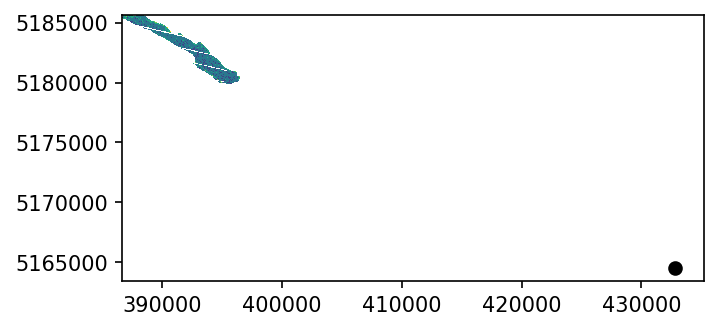

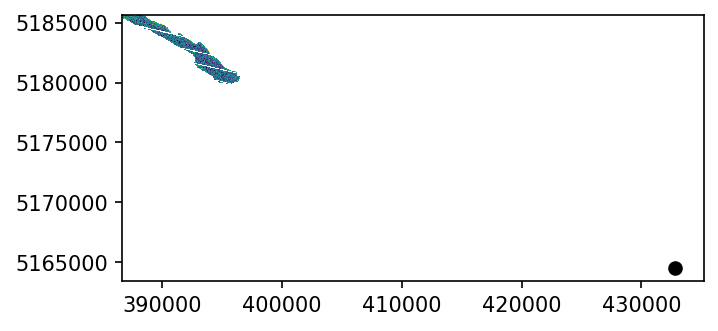

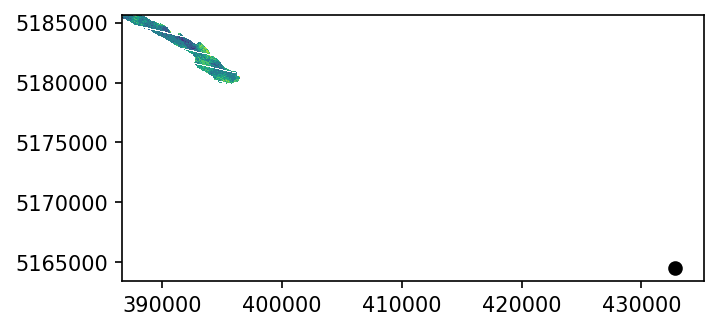

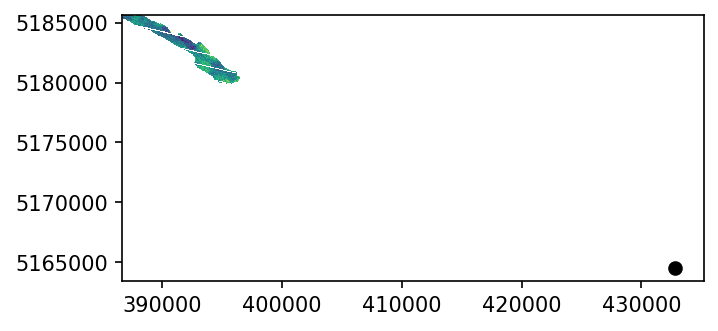

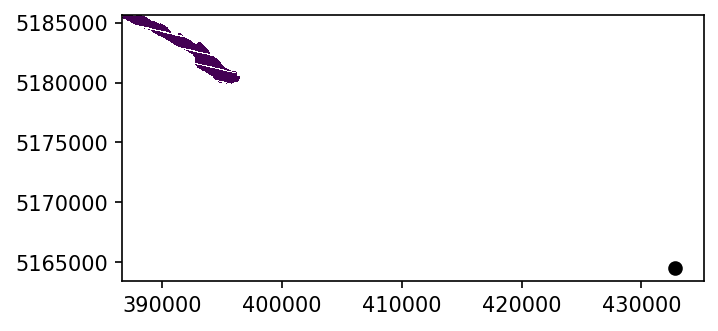

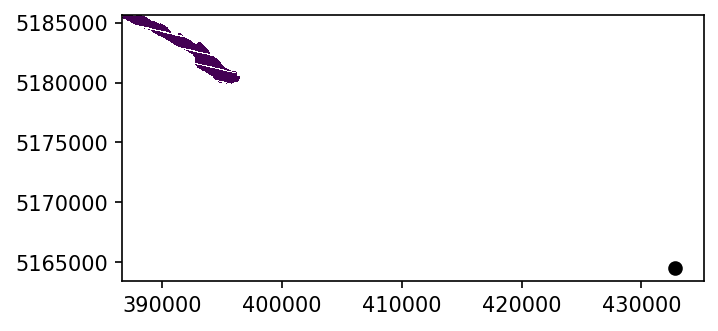

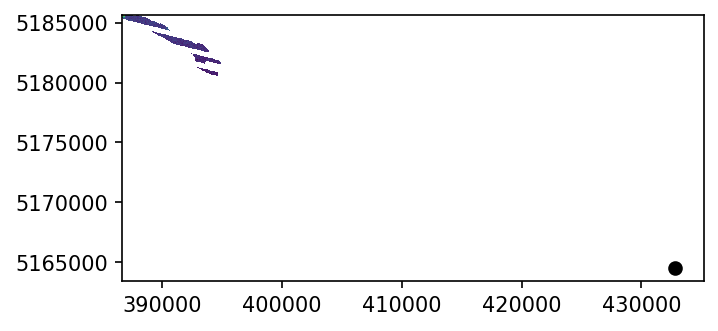

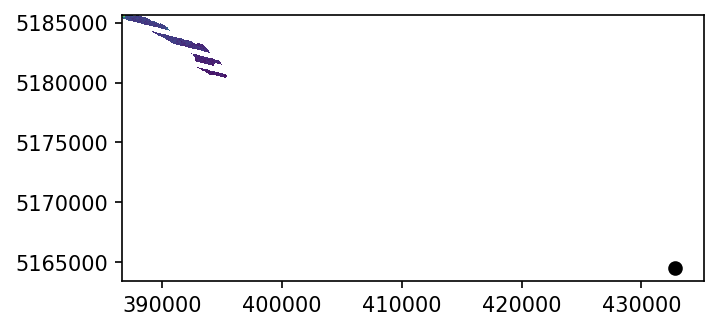

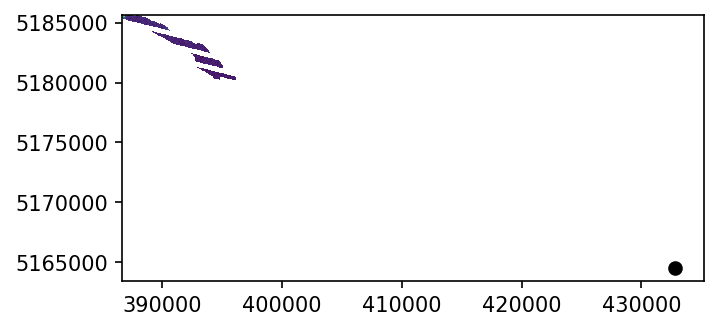

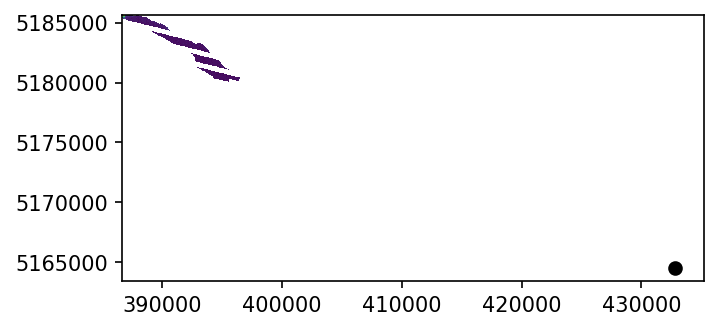

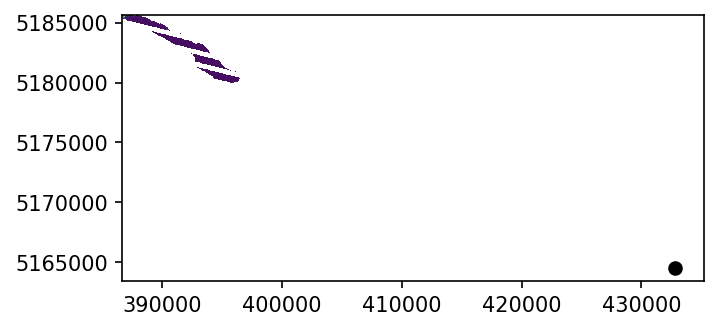

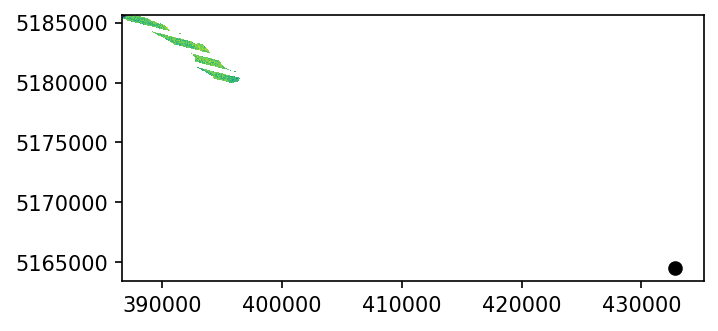

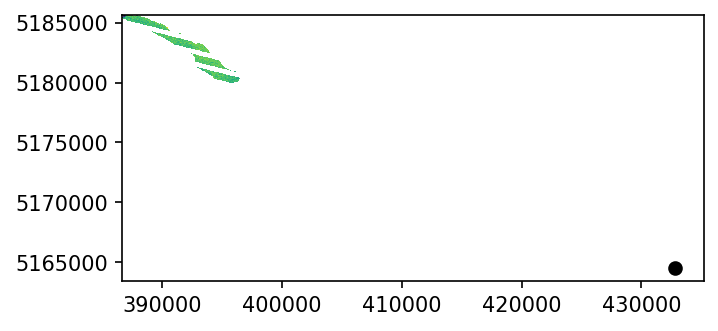

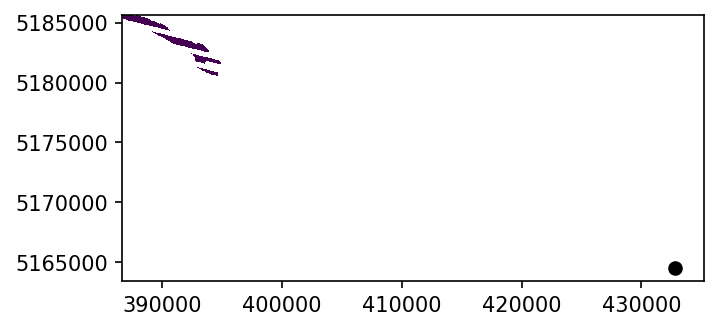

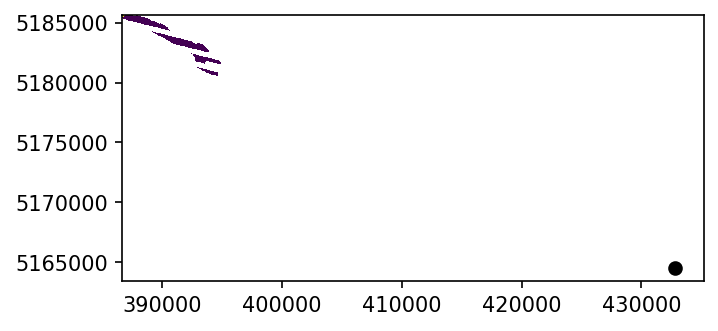

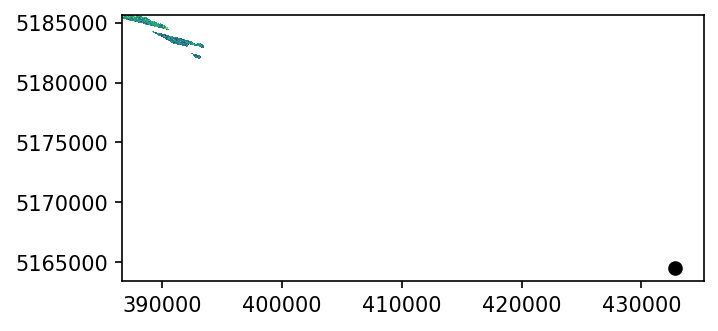

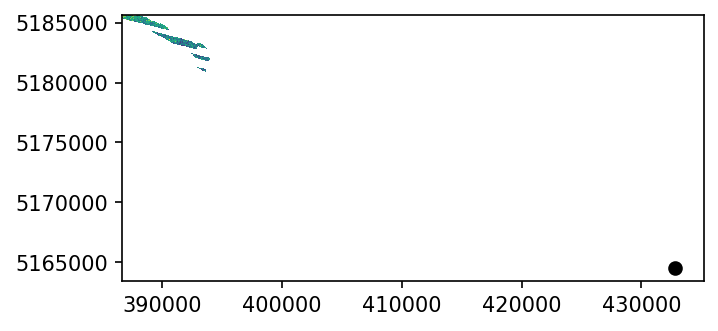

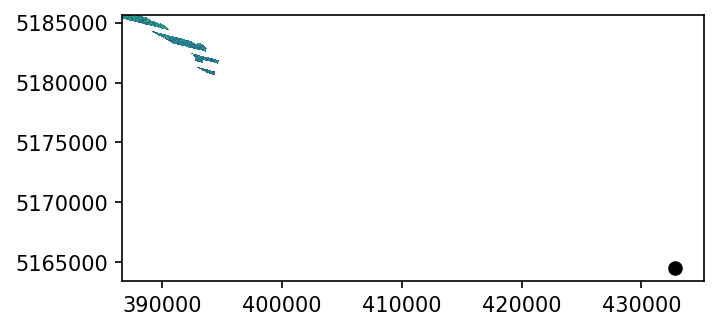

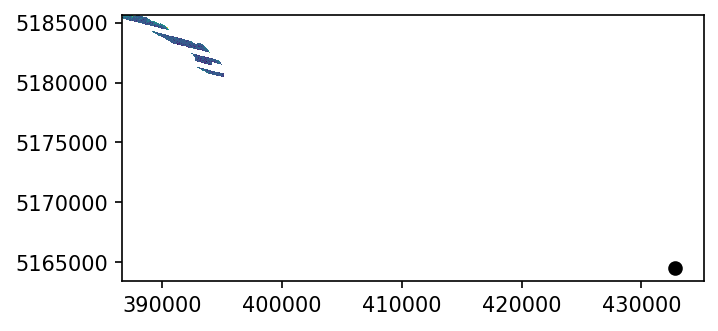

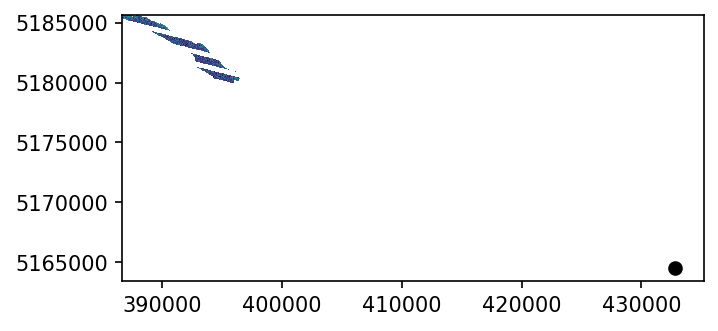

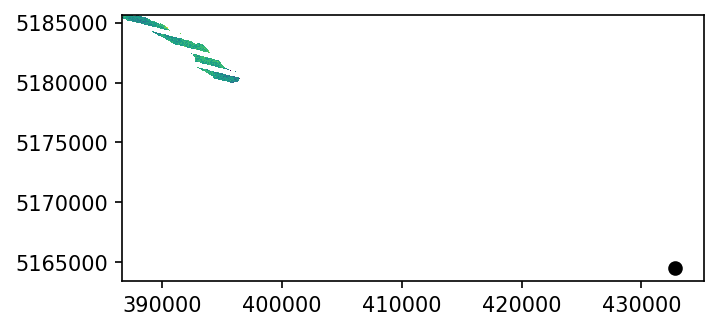

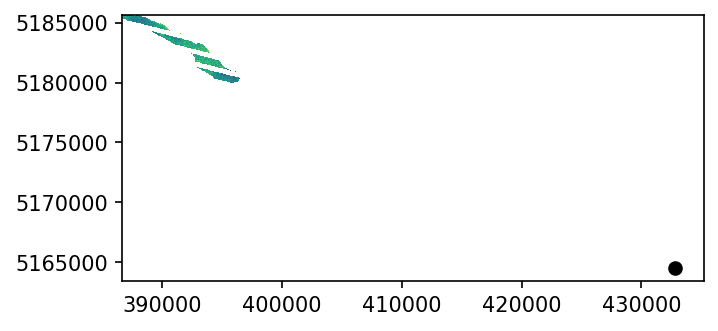

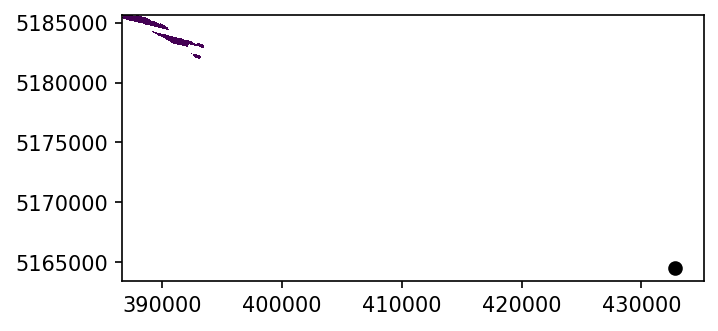

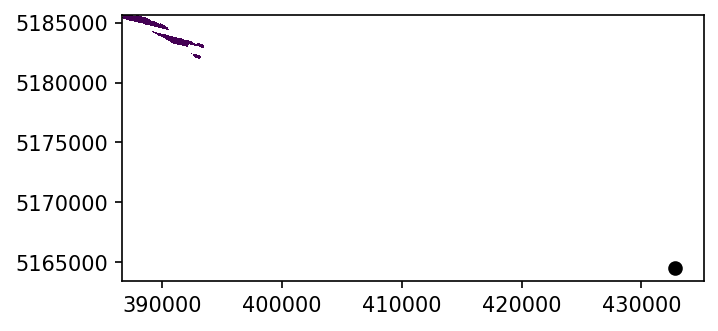

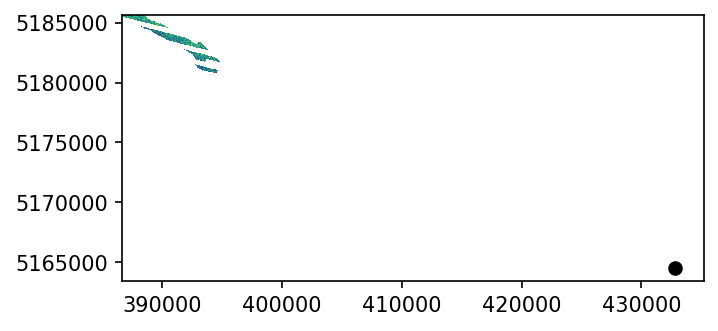

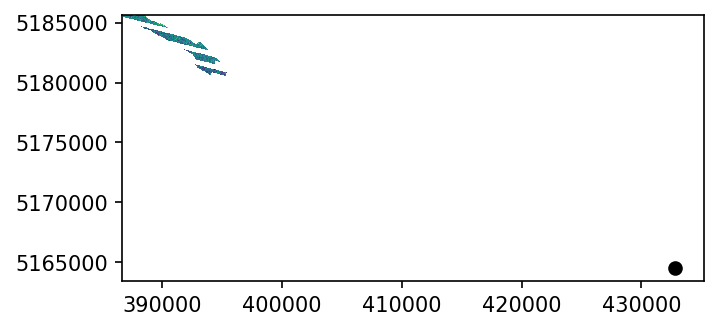

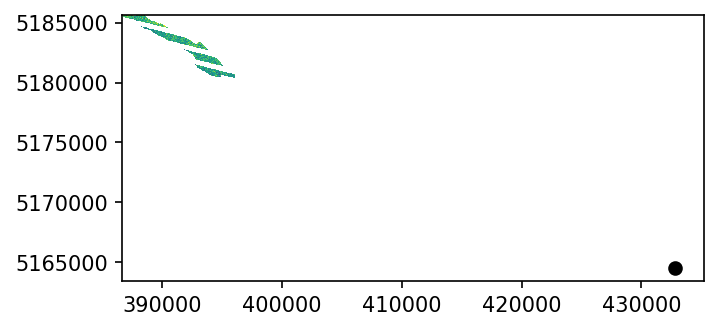

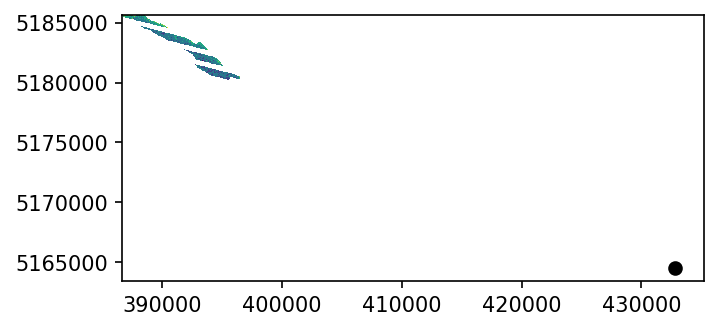

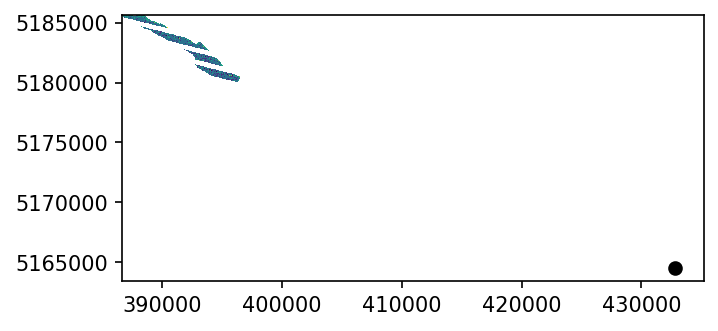

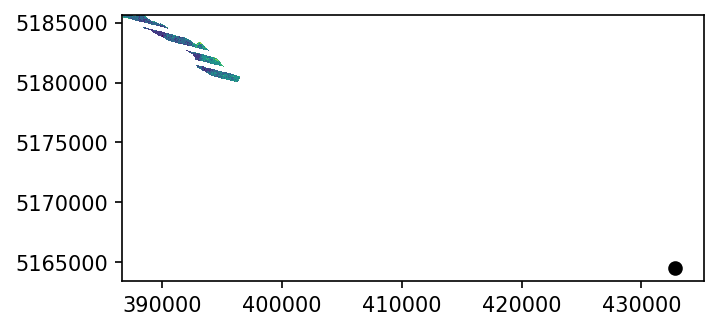

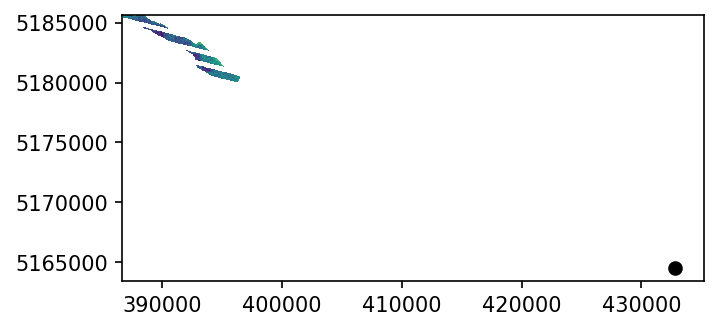

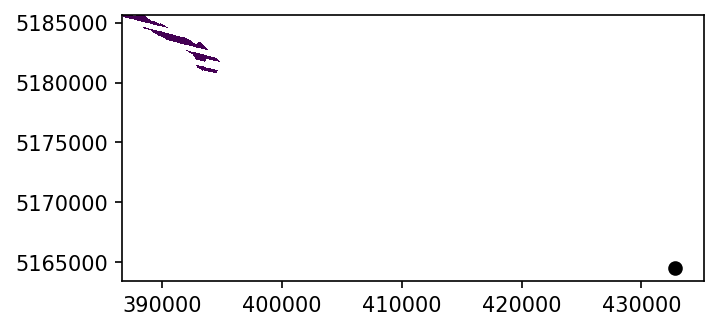

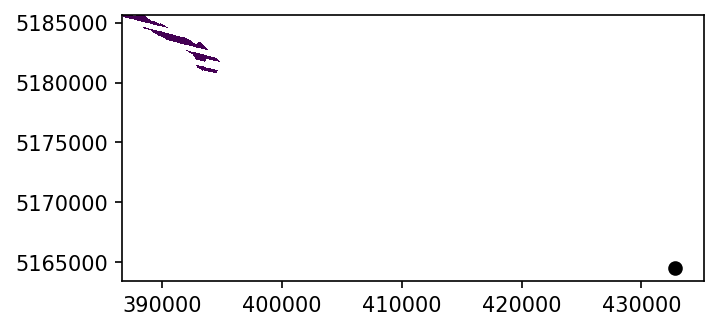

In [276]:
os.chdir("C:/Users/User/University College London/O'Sullivan, Aidan - SDG6/Landsat data/Corrected data")

dl_files = os.listdir()

for sid in sites.index.get_level_values(0).unique()[0:2]:
    
    sid_files = [ i for i in dl_files if sid in i ]
    
    for ras in sid_files:
        
        with rio.open(ras) as src:            

            pt = sites.loc[sid,:].set_geometry('geometry_ll')             

            ## change crs of pt
            original_crs = sites.crs
            pt = pt.to_crs(src.crs)

            ## change crs of poly
            poly = pt.set_geometry('geometry_poly')
            poly.crs = original_crs
            poly = poly.to_crs(src.crs)
                 
            
    
        src.close()
        
        path = "C:/Users/User/University College London/O'Sullivan, Aidan - SDG6/Landsat data/Pixels/"+ras
        
        src,count,buf_dis = crop_xpixels_point(pts,ras,poly,-100,9,path)
 
        fig, ax = plt.subplots(dpi=150, figsize =(5, 3))

        show(src,ax=ax)
        pts.plot(ax=ax,color='k')

        data = src.read(1)
        len(data[data>0])